In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 6
fig_height = 4
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"/Users/hirofumi48/162348.github.io/posts/2024/Process"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


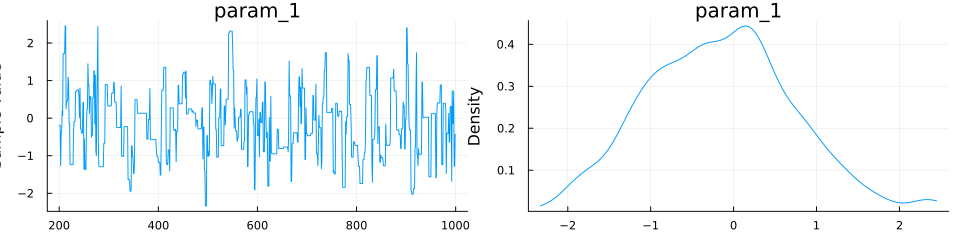

In [2]:
# Taken from https://mvihola.github.io/docs/AdaptiveMCMC.jl/

# Load the package
using AdaptiveMCMC

# Define a function which returns log-density values:
log_p(x) = -.5*sum(x.^2)

# Run 10k iterations of the Adaptive Metropolis:
out = adaptive_rwm(zeros(2), log_p, 1_000; algorithm=:am)

using MCMCChains, StatsPlots # Assuming MCMCChains & StatsPlots are installed...
c = Chains(out.X[1,:], start=out.params.b, thin=out.params.thin); plot(c)

Accept ratio Metropolis: 0.40874


Accept ratio emcee: 0.40874


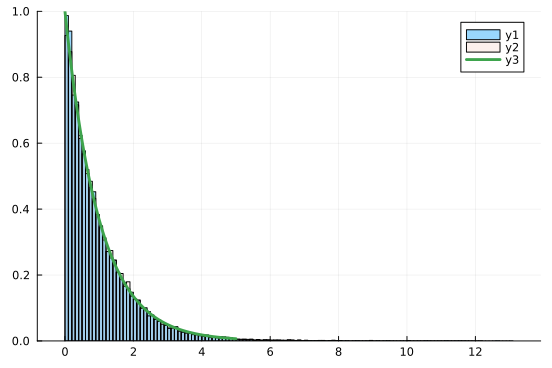

In [3]:
using KissMCMC
# the distribution to sample from,
logpdf(x::T) where {T} = x<0 ? -convert(T,Inf) : -x  # <1>
# initial point of walker
theta0 = 0.5

# Metropolis MCMC sampler:
sample_prop_normal(theta) = 1.5*randn() + theta # samples the proposal (or jump) distribution
thetas, accept_ratio = metropolis(logpdf, sample_prop_normal, theta0, niter=10^5)
println("Accept ratio Metropolis: $accept_ratio")

# emcee MCMC sampler:
thetase, accept_ratioe = emcee(logpdf, make_theta0s(theta0, 0.1, logpdf, 100), niter=10^5)
# check convergence using integrated autocorrelation
thetase, accept_ratioe = squash_walkers(thetase, accept_ratioe) # puts all walkers into one
println("Accept ratio emcee: $accept_ratio")

using Plots
histogram(thetas, normalize=true, fillalpha=0.4)
histogram!(thetase, normalize=true, fillalpha=0.1)
plot!(0:0.01:5, map(x->exp(logpdf(x)[1]), 0:0.01:5), lw=3)

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter ~/.julia/packages/ProgressMeter/dMfiC/src/ProgressMeter.jl:594
Sampling 100%|███████████████████████████████| Time: 0:00:00
  iterations:                                   2000
  ratio_divergent_transitions:                  0.02
  ratio_divergent_transitions_during_adaption:  0.0
  n_steps:                                      5
  is_accept:                                    true
  acceptance_rate:                              0.4107215318437009
  log_density:                                  -11.294421860681428
  hamiltonian_energy:                           13.857980312677872
  hamiltonian_energy_error:                     0.0
  max_hamiltonian_energy_err

┌ Info: Finished 2000 sampling steps for 1 chains in 1.237163583 (s)
│   h = Hamiltonian(metric=DiagEuclideanMetric([1.0]), kinetic=GaussianKinetic())
│   κ = HMCKernel{AdvancedHMC.FullMomentumRefreshment, Trajectory{MultinomialTS, Leapfrog{Float64}, GeneralisedNoUTurn{Float64}}}(AdvancedHMC.FullMomentumRefreshment(), Trajectory{MultinomialTS}(integrator=Leapfrog(ϵ=184.0), tc=GeneralisedNoUTurn{Float64}(10, 1000.0)))
│   EBFMI_est = 0.28000340456252204
└   average_acceptance_rate = 0.25931888387828284


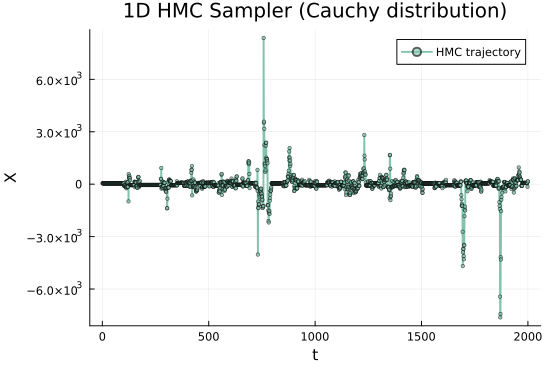

In [4]:
#| fig-cap: "スタート地点を 50 にした場合"
using AdvancedHMC, ForwardDiff
using LogDensityProblems
using LinearAlgebra
using Plots

struct LogTargetDensityCauchy
    loc::Float64
    scale::Float64
end

# Define the target distribution (1D Cauchy) using the `LogDensityProblem` interface

LogDensityProblems.logdensity(p::LogTargetDensityCauchy, θ) = -log(π) - log(p.scale) - log(1 + ((θ[1] - p.loc)/p.scale)^2)
LogDensityProblems.dimension(p::LogTargetDensityCauchy) = 1
LogDensityProblems.capabilities(::Type{LogTargetDensityCauchy}) = LogDensityProblems.LogDensityOrder{0}()

function HMC_sample(initial_θ)

    # Choose initial parameter value for 1D
    initial_θ = [initial_θ]

    # Define the Cauchy distribution with location and scale
    loc, scale = 0.0, 1.0
    ℓπ = LogTargetDensityCauchy(loc, scale)

    # Set the number of samples to draw and warmup iterations
    n_samples, n_adapts = 2_000, 1

    # Define a Hamiltonian system
    metric = DiagEuclideanMetric(1)
    hamiltonian = Hamiltonian(metric, ℓπ, ForwardDiff)

    # Define a leapfrog solver, with the initial step size chosen heuristically
    initial_ϵ = find_good_stepsize(hamiltonian, initial_θ)
    integrator = Leapfrog(initial_ϵ)

    # Define an HMC sampler with the following components
    #   - multinomial sampling scheme,
    #   - generalised No-U-Turn criteria, and
    #   - windowed adaption for step-size and diagonal mass matrix
    kernel = HMCKernel(Trajectory{MultinomialTS}(integrator, GeneralisedNoUTurn()))
    adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.8, integrator))

    # Run the sampler to draw samples from the specified Cauchy distribution, where
    #   - `samples` will store the samples
    #   - `stats` will store diagnostic statistics for each sample
    samples, stats = sample(hamiltonian, kernel, initial_θ, n_samples, adaptor, n_adapts; progress=true)

    # Print the results
    sample_values = [s[1] for s in samples]

    p = plot(1:length(samples), sample_values,
                label="HMC trajectory",
                title="1D HMC Sampler (Cauchy distribution)",
                xlabel="t",
                ylabel="X",
                linewidth=2,
                marker=:circle,
                markersize=2,
                markeralpha=0.6,
                color="#80c4ac")
end

HMC_sample(50.0)

┌ Info: Finished 2000 sampling steps for 1 chains in 0.066639042 (s)
│   h = Hamiltonian(metric=DiagEuclideanMetric([1.0]), kinetic=GaussianKinetic())
│   κ = HMCKernel{AdvancedHMC.FullMomentumRefreshment, Trajectory{MultinomialTS, Leapfrog{Float64}, GeneralisedNoUTurn{Float64}}}(AdvancedHMC.FullMomentumRefreshment(), Trajectory{MultinomialTS}(integrator=Leapfrog(ϵ=5.95), tc=GeneralisedNoUTurn{Float64}(10, 1000.0)))
│   EBFMI_est = 0.5485390698552097
└   average_acceptance_rate = 0.15690859394003223


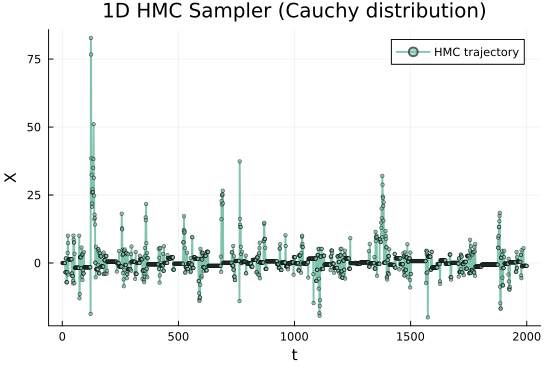

In [5]:
#| fig-cap: "スタート地点を 0 にした場合"
HMC_sample(0.0)

┌ Info: Finished 2000 sampling steps for 1 chains in 0.036209583 (s)
│   h = Hamiltonian(metric=DiagEuclideanMetric([1.0]), kinetic=GaussianKinetic())
│   κ = HMCKernel{AdvancedHMC.FullMomentumRefreshment, Trajectory{MultinomialTS, Leapfrog{Float64}, GeneralisedNoUTurn{Float64}}}(AdvancedHMC.FullMomentumRefreshment(), Trajectory{MultinomialTS}(integrator=Leapfrog(ϵ=1980.0), tc=GeneralisedNoUTurn{Float64}(10, 1000.0)))
│   EBFMI_est = 1.97505602071011
└   average_acceptance_rate = 2.7408010018857654e-5


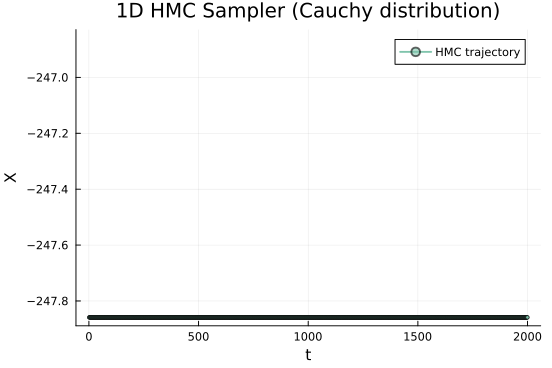

In [6]:
#| fig-cap: "スタート地点を 500 にした場合"
HMC_sample(500.0)

┌ Info: Finished 2000 sampling steps for 1 chains in 0.04807225 (s)
│   h = Hamiltonian(metric=DiagEuclideanMetric([1.0]), kinetic=GaussianKinetic())
│   κ = HMCKernel{AdvancedHMC.FullMomentumRefreshment, Trajectory{MultinomialTS, Leapfrog{Float64}, GeneralisedNoUTurn{Float64}}}(AdvancedHMC.FullMomentumRefreshment(), Trajectory{MultinomialTS}(integrator=Leapfrog(ϵ=256.0), tc=GeneralisedNoUTurn{Float64}(10, 1000.0)))
│   EBFMI_est = 0.273256285624901
└   average_acceptance_rate = 0.21470633042303017


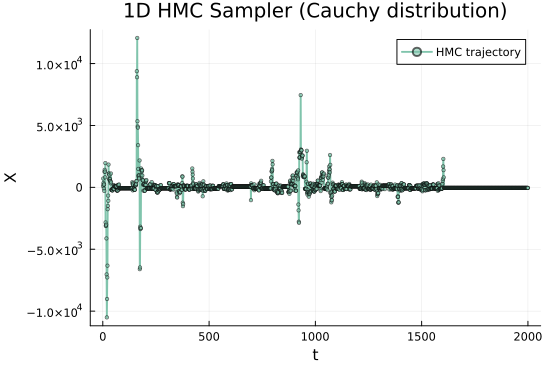

In [7]:
#| fig-cap: "スタート地点を 100 にした場合"
HMC_sample(100.0)

In [8]:
using AdvancedMH
using Distributions
using MCMCChains
using ForwardDiff
using StructArrays
using LinearAlgebra
using LogDensityProblems
using LogDensityProblemsAD

# Generate a set of data from the posterior we want to estimate.
data = rand(Normal(0, 1), 30)

# Define the components of a basic model.
struct LogTargetDensityCauchy
    loc::Float64
    scale::Float64
end

LogDensityProblems.logdensity(p::LogTargetDensityCauchy, θ) = -log(π) - log(p.scale) - log(1 + ((θ[1] - p.loc)/p.scale)^2)
LogDensityProblems.dimension(p::LogTargetDensityCauchy) = 1
LogDensityProblems.capabilities(::Type{LogTargetDensityCauchy}) = LogDensityProblems.LogDensityOrder{0}()

# Use automatic differentiation to compute gradients
model_with_ad = LogDensityProblemsAD.ADgradient(Val(:ForwardDiff), LogTargetDensityCauchy(0.0, 1.0))

# Set up the sampler with a multivariate Gaussian proposal.
σ² = 0.01
spl = MALA(x -> MvNormal((σ² / 2) .* x, σ² * I))
#spl = RWMH(MvNormal(zeros(2), I))

# Sample from the posterior.
chain = sample(model_with_ad, spl, 1000; initial_params=ones(2), chain_type=StructArray, param_names=["μ", "σ"])

1000-element StructArray(::Vector{Float64}, ::Vector{Float64}, ::Vector{Float64}) with eltype @NamedTuple{μ::Float64, σ::Float64, lp::Float64}:
 (μ = 1.0, σ = 1.0, lp = -1.8378770664093453)
 (μ = 0.9431532170126006, σ = 1.0097419035567927, lp = -1.781062235705654)
 (μ = 0.8092973309775762, σ = 1.02772935312087, lp = -1.6485080363672848)
 (μ = 0.8345350158027784, σ = 0.9955251339795068, lp = -1.6732669475460606)
 (μ = 0.7841995222940966, σ = 1.0644651490816157, lp = -1.6240455796550801)
 (μ = 0.9148260196458521, σ = 1.0363556845908024, lp = -1.7528128721852403)
 (μ = 0.8276977150514409, σ = 0.9426706048604031, lp = -1.666545007773699)
 (μ = 0.7950234099935971, σ = 1.1033182582092056, lp = -1.634574268158298)
 (μ = 0.946115887290524, σ = 1.060897353849369, lp = -1.7840201055741054)
 (μ = 0.8586119834787284, σ = 0.988788860392024, lp = -1.6970128762318462)
 (μ = 0.9393396311586089, σ = 0.994700945417436, lp = -1.777255632878711)
 (μ = 0.9809970540281309, σ = 1.1499657028209915, lp = -1.81